# Analysis of Tuning Properties
This tutorial shows how to generate the plots showing how well the units are tuned to a particular kinematic feature as found in Figure 5 of the paper

This script should be run using the libraries from the environment.yml file.

In [122]:
#from pyglmnet import GLM
import numpy as np
import matplotlib
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#from dir_tuning_alllayers_mp import *
import matplotlib.patches as mpatches
from rowwise_neuron_curves import *
import pickle
import os
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from main import RunInfo

# %% VARIABLES

muscle_order = ['CORB', 'DELT1', 'DELT2', 'DELT3', 'INFSP', 'LAT1', 'LAT2', 'LAT3', 'PECM1', 
                'PECM2', 'PECM3', 'SUBSC', 'SUPSP', 'TMAJ', 'TMIN', 'ANC', 'BIClong', 'BICshort', 
                'BRA', 'BRD', 'ECRL', 'PT', 'TRIlat', 'TRIlong', 'TRImed']

In [131]:
modelinfo = dict({'type': 'S',
            'typename': 'spatial_temporal',
            'base': 'spatial_temporal_4_8-16-16-32_32-32-64-64_7293',
            'base_regression': 'spatial_temporal_r_4_8-16-16-32_32-32-64-64_7293',
            'name': 'spatial_temporal_4_8-16-16-32_32-32-64-64_7293_1',
            'nlayers': 8,
            'max_nlayers': 8,
            'max_act': 14, #this can be manually adjusted as the maximum in the preferred direction histogram
            'control': False,
            'cmap': matplotlib.colors.ListedColormap(['midnightblue']),
            'color': 'midnightblue',
            'regression_color': 'darkturquoise',
            'control_cmap': 'Greys_r',
            'regression_cmap': matplotlib.colors.ListedColormap(['darkturquoise']),
            's_stride': 2,
            't_stride': 3,
            'regression_task': False,
            'model_path': None,
            'exp_id': None,})

runinfo = RunInfo({'expid': 402, #internal experiment id
                   'datafraction': 0.5,
                   'randomseed': 2000,
                   'randomseed_traintest': 42,
                   'dirr2threshold': 0.2,
                   'verbose': 0,
                   'model_experiment_id': 4, #as per Pranav's model generation
                   'basefolder' : '/media/data/DeepDraw/revisions/analysis-data/', ## change this folder to redirect to where the analysis-data folder is saved locally, including trailing slash
                   'orientation' : 'hor',
                   'height' : 'all'
            })

## Combined Violin Quantiles

In [116]:
def format_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6)
    ax.yaxis.set_tick_params(size=6)
    
def clip(vp, lr):
    
    for b in vp['bodies']:
        m = np.mean(b.get_paths()[0].vertices[:, 0])
    
        if lr == 'l':
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
        elif lr == 'r':
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)   

In [117]:
t_stride = 2
ntime=320
metrics = ['RMSE', 'r2', 'PCC']
nmetrics = len(metrics)
expid = 100
fset = 'vel'
mmod = 'std'
tcoff = 32

modnames = ['Dir', 'Vel', 'Dir x Vel', 'Acc', 'Labels']
nmods = len(modnames)

In [118]:
def get_modevals(model, runinfo):
    ''' Read in tuning curve fits from saved numpy files
    
    Arguments
    ---------
    model : dict, information about current model
    runinfo : RunInfo (extension of dict), information about experimental run
    
    Returns
    -------
    modevals : list of lists containing tuning curve test r2 strengths for five different model types to be plotted
        Outer list: layers; Inner list: Model types, containing np.array of r2 strengths
        
    '''
    
    expf={
          'vel': runinfo.resultsfolder(model, 'vel'),
          'acc': runinfo.resultsfolder(model, 'acc'),
          'labels': runinfo.resultsfolder(model, 'labels')
    }
    
    # READ IN OF REGS AND THRESHOLD, SAVE TEXT FILE
    modevals = []
    
    for i in range(nmods):
        modevals.append([])
    
    for ilayer in np.arange(0,model['nlayers'] + 1):
        
        dvevals = np.load(os.path.join(expf['vel'], 'l%d_%s_mets_%s_%s_test.npy' %(ilayer, 'vel', mmod, runinfo.planestring())))
        accevals = np.load(os.path.join(expf['acc'], 'l%d_%s_mets_%s_%s_test.npy' %(ilayer, 'acc', 'std',runinfo.planestring())))
        labevals = np.load(os.path.join(expf['labels'], 'l%d_%s_mets_%s_%s_test.npy' %(ilayer, 'labels', 'std', runinfo.planestring())))
        
        modevals[0].append(dvevals[...,1,1]) #dir
        modevals[1].append(dvevals[...,2,1]) #vel
        modevals[2].append(dvevals[...,3,1]) #dir + vel
        modevals[3].append(accevals[...,2,1]) #acc
        modevals[4].append(labevals[:,0]) #labels
        
        
    return modevals

In [119]:
trainedmodel = modelinfo.copy()
trainedmodevals = get_modevals(trainedmodel, runinfo)

controlmodel = modelinfo.copy()
controlmodel['name'] = controlmodel['name'] + 'r'
controlmodevals = get_modevals(controlmodel, runinfo)

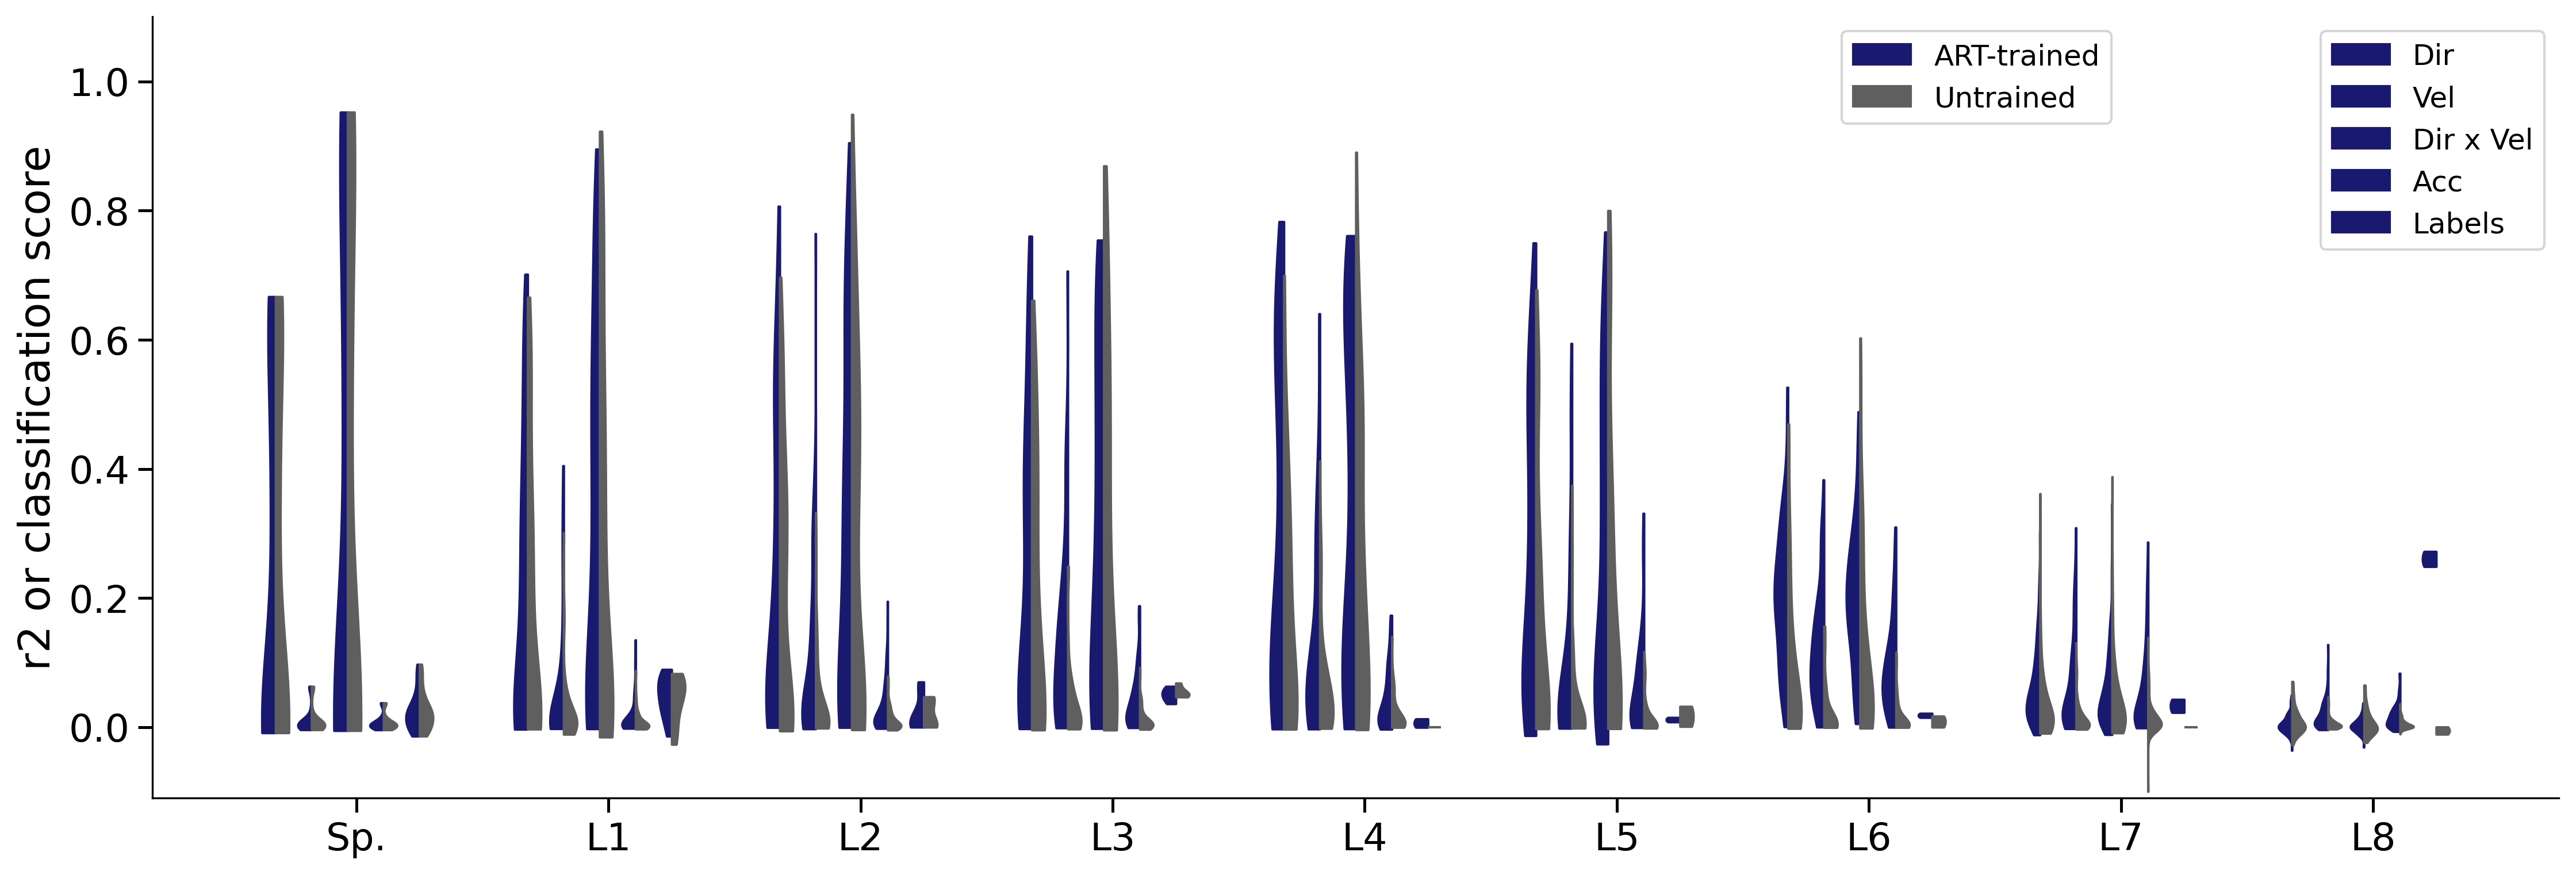

In [129]:
regcomp=False
    
nlayers = trainedmodel['nlayers'] + 1

space = 0.8
width = 0.6
lspace = space*nmods + 1.6

trainedcmap = matplotlib.cm.get_cmap(trainedmodel['cmap']) #spatial_temporal    

if not regcomp:
    controlcmap = matplotlib.cm.get_cmap('Greys_r') #spatial_temporal    
else:
    controlcmap = matplotlib.cm.get_cmap(trainedmodel['regression_cmap'])

## SET OTHER PLOTTING VARIABLES

ct = 0.6
cidx = [i*(1-ct)/(nmods-1) for i in range(nmods)] #Blues_r option
#plot figure
fig = plt.figure(figsize=(18,6), dpi=300)
ax1 = fig.add_subplot(111)

plt.xticks(np.arange(lspace/2,nlayers*lspace + 1,lspace), 
            ['Sp.'] + ['L%d' %i for i in np.arange(1, nlayers)])

ax1.set_ylabel('r2 or classification score')
ax1.set_ylim(-0.11, 1.1)
vps = []
patches = []

ccolorindex = 3
for (modevals, cmap, alpha, zorder, lr) in zip([controlmodevals, trainedmodevals], [controlcmap, trainedcmap], [[1, 1], [1, 1]], [2,1], ['r', 'l']):
    for i, mod in enumerate(modevals):
        
        mod = [x.reshape((-1,)) for x in mod]

        ##exclude r2 == 1 scores and r2 < -0.1
        mod = [x[(x != 1) & (x > -0.1)] for x in mod]

        try:
        
            vp = ax1.violinplot(mod,
                positions=[ilayer*lspace+space*i+1 for ilayer in range(nlayers)], 
                showextrema = False,
                showmedians = False,
                showmeans = False,
                widths=width)
            
            for part in vp['bodies']:
                if lr == 'l':
                    part.set_facecolor(cmap(cidx[i]))
                    part.set_edgecolor(cmap(cidx[i]))
                else:
                    if not regcomp:
                        part.set_facecolor(cmap(cidx[ccolorindex]))
                        part.set_edgecolor(cmap(cidx[ccolorindex]))
                    else:
                        part.set_facecolor(cmap(cidx[i]))
                        part.set_edgecolor(cmap(cidx[i]))
                part.set_alpha(alpha[1])
                part.set_zorder(zorder)
    
            try:
                clip(vp, lr)
            except IndexError as e:
                print(e)
                print("not enough samples for ", lr)
                print(vp)       

        except ValueError as e:
            print("empty array, can't do violin plot", e)
            vp = None     
        patches.append(mpatches.Patch(color=cmap(cidx[i]), alpha=1))
        #patches.append(mpatches.Patch(color=matplotlib.cm.get_cmap('Greys_r') (cidx[i]), alpha=0.7)) ##eLife
        
        
        vps.append(vp)

format_axis(plt.gca())
format_axis(ax1)

leg = plt.legend(patches[5:], modnames, loc='upper right')
ax1.add_artist(leg)
if not regcomp:
    if not trainedmodel['regression_task']:
        plt.legend([patches[5], patches[ccolorindex]], ['ART-trained', 'Untrained'], loc='upper right', bbox_to_anchor=(0.82, 1))
    else:
        plt.legend([patches[5], patches[ccolorindex]], ['TDT-trained', 'Untrained'], loc='upper right', bbox_to_anchor=(0.82, 1))
else:
    plt.legend([patches[5], patches[ccolorindex]], ['ART', 'TDT'], loc='upper right', bbox_to_anchor=(0.82, 1))

plt.show()

fig

## Direction & Acceleration 90% Quantile Comparisons

In [132]:
analysisfolder = runinfo.sharedanalysisfolder(modelinfo, 'kindiffs')
df = pd.read_csv(os.path.join(analysisfolder, modelinfo['base'] + '_comparisons_df.csv'),
                 header=0, index_col=[0,1,2], dtype={'layer': int, 'mean': float, 'median': float})
tcfdf = df.loc[(slice(None), slice(None), ['dir', 'acc']), 'q90']
nlayers = modelinfo['nlayers']

In [133]:

def colorselector(cmapname, tcf, ct = 0.4):
    ''' Helper function to select color for kinematic tuning curve types and labels
    
    Arguments
    ---------
    cmapname : str, the name of the color map that is being used 
    tcf : str, name of tuning feature that is being plotted
    ct : int, opt, specifies range of colorbar that is used
    
    Returns
    -------
    color values
    '''
    
    tcnames = ['dir', 'vel', 'dirvel', 'acc', 'labels']
    nmods = len(tcnames)
    tci = tcnames.index(tcf)
    
    cmap = matplotlib.cm.get_cmap(cmapname)
    cidx = tci*(1-ct)/(nmods-1)
    return cmap(cidx)

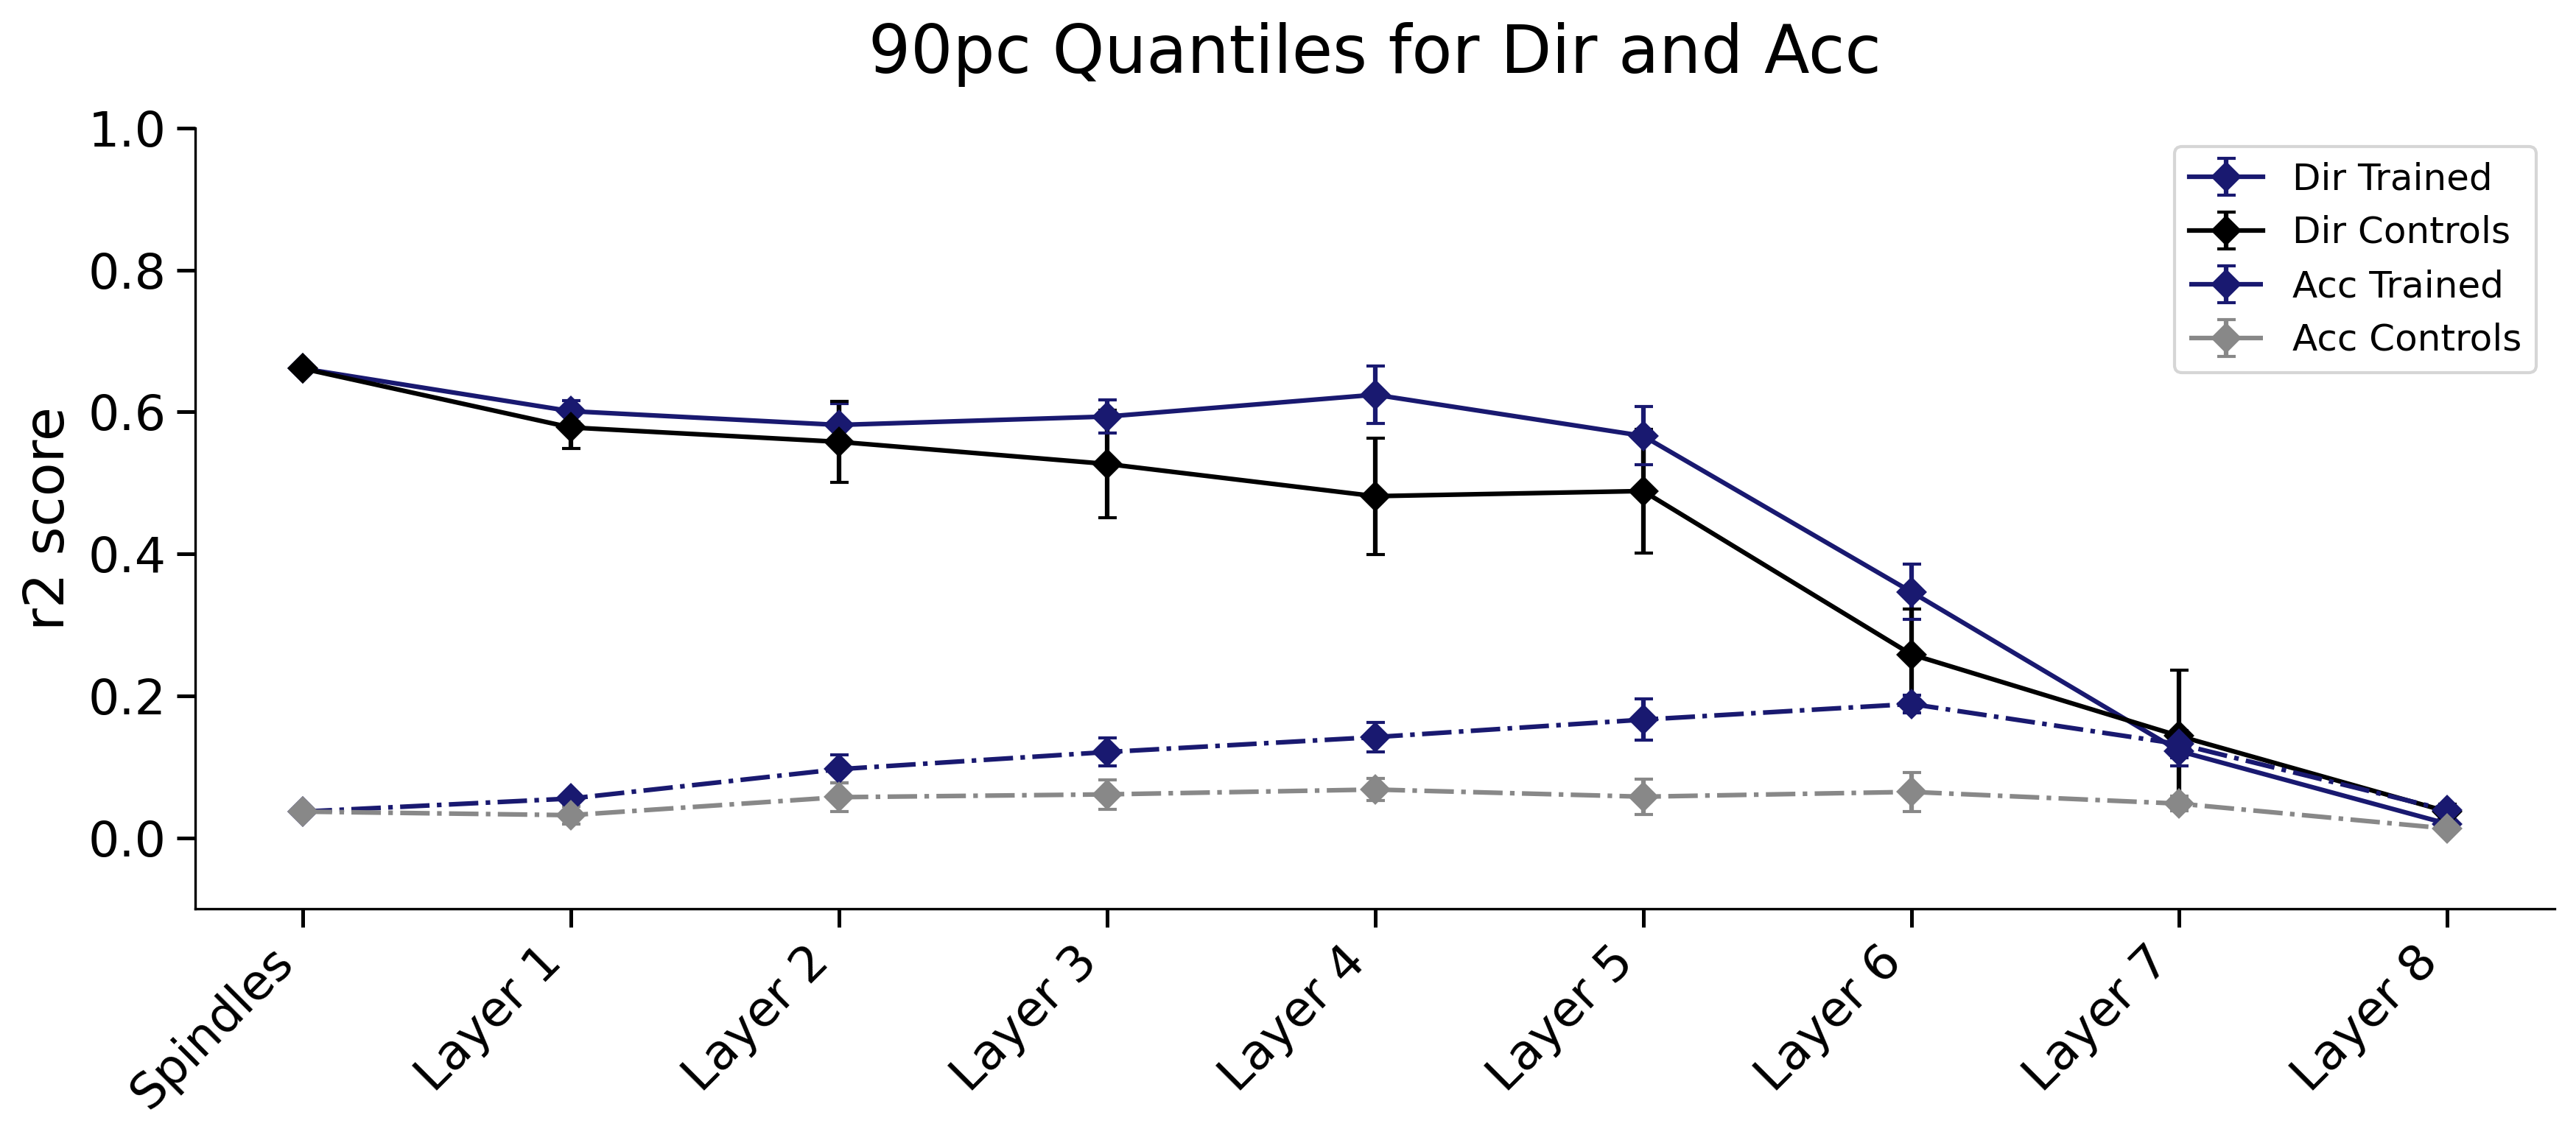

In [135]:
fig = plt.figure(figsize=(12,5.5), dpi=300)   
ax = fig.add_subplot(111)

trainednamer = lambda i: modelinfo['base'] + '_%d' %i
trainednames = [trainednamer(i) for i in np.arange(1,6)]

controlnamer = lambda i: modelinfo['base'] + '_%dr' %i
controlnames = [controlnamer(i) for i in np.arange(1,6)]

x = range(nlayers + 1)

#solution to calculate conf. interval of means from https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.t.html
from scipy.stats import t
t_corr = t.ppf(0.975, 4)

traineddirs = [tcfdf.loc[(trainednames, i, 'dir')].mean() for i in np.arange(nlayers+1)]
controldirs = [tcfdf.loc[(controlnames, i, 'dir')].mean() for i in np.arange(nlayers+1)]
errs_traineddirs = [tcfdf.loc[(trainednames, i, 'dir')].std()/np.sqrt(5) * t_corr for i in np.arange(nlayers+1)]
errs_controldirs = [tcfdf.loc[(controlnames, i, 'dir')].std()/np.sqrt(5) * t_corr for i in np.arange(nlayers+1)]

trainedlabels = [tcfdf.loc[(trainednames, i, 'acc')].mean() for i in np.arange(nlayers+1)]
controllabels = [tcfdf.loc[(controlnames, i, 'acc')].mean() for i in np.arange(nlayers+1)]
errs_trainedlabels = [tcfdf.loc[(trainednames, i, 'acc')].std()/np.sqrt(5) * t_corr for i in np.arange(nlayers+1)]
errs_controllabels = [tcfdf.loc[(controlnames, i, 'acc')].std()/np.sqrt(5) * t_corr for i in np.arange(nlayers+1)]

plt.errorbar(x, traineddirs, yerr=errs_traineddirs, color=colorselector(modelinfo['cmap'], 'dir'), marker='D', capsize=3.0)
plt.errorbar(x, controldirs, yerr=errs_controldirs, color=colorselector('Greys_r', 'dir'), marker='D', capsize=3.0)
plt.errorbar(x, trainedlabels, yerr=errs_trainedlabels, color=colorselector(modelinfo['cmap'], 'acc'), linestyle='-.',marker='D', capsize=3.0)
plt.errorbar(x, controllabels, yerr=errs_controllabels, color=colorselector('Greys_r', 'acc'), linestyle='-.', marker='D', capsize=3.0)
plt.ylabel('r2 score')
plt.xticks(np.array(x), ['Spindles'] + ['Layer %d' %i for i in np.arange(1,nlayers+1)], rotation=45,
           horizontalalignment = 'right')
plt.ylim((-0.1,1))

handles, _ = ax.get_legend_handles_labels()
handles = np.array(handles)
plt.legend(['Dir Trained', 'Dir Controls', \
            'Acc Trained', 'Acc Controls'])

ax = format_axis(ax)

plt.title('90pc Quantiles for Dir and Acc')
plt.tight_layout()
fig